# Mechanisms of Action (MoA) Prediction - Final Classifier
## Train

In this notebook, we will implement the full train pipeline, inclusive of feature engineering, model preparation, as well as any other meta-classifiers or pre-final classifier algorithms. Namely, the zero_label classifier - this has shown some positive performance on the leaderboard, but was not overwhelmingly positive, so we will experiment with the best location in the pipeline to put this in.

When a promising baseline model is created, we will run Bayesian hyperparameter optimisation as part of our CV strategy. The model will be trained on multiple seeds also, so we can ensemble those too at the end. By the time the final submission is ready to be produced, we will have numerous models and model seeds, all optimised as much as possible, to ensemble for the final predictions. 


## 1.00 Import Packages

In [1]:
# General packages
import pandas as pd
import numpy as np
import os
import gc
import random
from tqdm import tqdm, tqdm_notebook

import time
import warnings
warnings.filterwarnings('ignore')

# Data vis packages
import matplotlib.pyplot as plt
%matplotlib inline

# Data prep
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA

# Modelling packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as k
# Key layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Add, Dense, Flatten
# Activation layers
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU, ThresholdedReLU
# Dropout layers
from tensorflow.keras.layers import Dropout, AlphaDropout, GaussianDropout
# Normalisation layers
from tensorflow.keras.layers import BatchNormalization
# Embedding layers
from tensorflow.keras.layers import Embedding, Concatenate, Reshape
# Callbacks
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint
# Optimisers
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
# Model cross validation and evaluation
from sklearn.model_selection import KFold
from tensorflow.keras.losses import binary_crossentropy

# For Bayesian hyperparameter searching
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

strategy = tf.distribute.get_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# Data access
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

Num GPUs Available:  1
REPLICAS: 1


## 2.00 Read in Data

In [3]:
# Directory and file paths
input_dir                 = '../input/lish-moa/'
train_features_path       = os.path.join(input_dir, 'train_features.csv')
test_features_path        = os.path.join(input_dir, 'test_features.csv')
train_targets_scored_path = os.path.join(input_dir, 'train_targets_scored.csv')
sample_submission_path    = os.path.join(input_dir, 'sample_submission.csv')

# Read in data
train_features       = pd.read_csv(train_features_path)
test_features        = pd.read_csv(test_features_path)
train_targets_scored = pd.read_csv(train_targets_scored_path)
sample_submission    = pd.read_csv(sample_submission_path)

del train_features_path, test_features_path, train_targets_scored_path, sample_submission_path

print(f'train_features shape: \t\t{train_features.shape}')
print(f'test_features shape: \t\t{test_features.shape}')
print(f'train_targets_scored shape: \t{train_targets_scored.shape}')
print(f'sample_submission shape: \t{sample_submission.shape}')

train_features shape: 		(23814, 876)
test_features shape: 		(3982, 876)
train_targets_scored shape: 	(23814, 207)
sample_submission shape: 	(3982, 207)


In [4]:
# Define key parameters
SEED = 19
np.random.seed(SEED)

SCALER_METHOD = RobustScaler()

FEATURE_SELECTOR = RandomForestClassifier(random_state=SEED)
NUM_FEATURES = 500

NUM_COMPONENTS = 200
PCA_METHOD = PCA(n_components=NUM_COMPONENTS, random_state=SEED)

EPOCHS = 100
BATCH_SIZE = 64
KFOLDS = 2
PATIENCE = 10

USE_EMBEDDING = True
MODEL_TO_USE = 'nn'
model_name_save = MODEL_TO_USE + '_final_classifier_seed' + str(SEED)

print(f'Model name: {model_name_save}')

Model name: nn_final_classifier_seed19


## 3.00 Data Preparation

### 3.01 Feature Engineering
Due to the high dimensionality of the data, our engineered features focus on record-level aggregations, for all numerical features as well as for g-features and c-features. A pipeline for features that use columns-wise aggregations is created but not executed (as this would allow for data leakage). These transformations will be made in-fold during cross validation.

In [5]:
X = train_features
y = train_targets_scored.drop('sig_id', axis=1)

In [6]:
def get_row_stat(df, stat, feat_type):
    """
    Input data and returns row level statistics.
    stat: str ['sum','mean','med','std','min','max']
    feat_type: str [None,'g','c']
    """
    
    # Separate features into numerical and categorical (and by feature type if specified)
    if feat_type == None:
        df_numerical = df.select_dtypes('number').drop('cp_time', axis=1)
        df_categorical = df.select_dtypes('object')
    elif feat_type == 'g':
        df_numerical = df.select_dtypes('number').drop('cp_time', axis=1)
        df_categorical = df.select_dtypes('object')
        # Subset to g features
        df_numerical = df_numerical[df_numerical.columns[df_numerical.columns.str.startswith('g-')]]
        df_categorical = df_categorical[df_categorical.columns[df_categorical.columns.str.startswith('g-')]]
    elif feat_type == 'c':
        df_numerical = df.select_dtypes('number').drop('cp_time', axis=1)
        df_categorical = df.select_dtypes('object')
        # Subset to g features
        df_numerical = df_numerical[df_numerical.columns[df_numerical.columns.str.startswith('c-')]]
        df_categorical = df_categorical[df_categorical.columns[df_categorical.columns.str.startswith('c-')]]
        
    # Add statistic feature
    if stat == 'sum':
        stat_feat = df_numerical.sum(axis=1)
    elif stat == 'mean':
        stat_feat = df_numerical.mean(axis=1)
    elif stat == 'med':
        stat_feat = df_numerical.median(axis=1)
    elif stat == 'std':
        stat_feat = df_numerical.std(axis=1)
    elif stat == 'min':
        stat_feat = df_numerical.min(axis=1)
    elif stat == 'max':
        stat_feat = df_numerical.max(axis=1)
    
    return(stat_feat)

In [7]:
# Get list of original column names (so we don't make transformations using new features)
X_cols = X.columns

# Total row stats
X['row_sum']  = get_row_stat(X[X_cols], stat='sum' , feat_type=None)
X['row_mean'] = get_row_stat(X[X_cols], stat='mean', feat_type=None)
X['row_med']  = get_row_stat(X[X_cols], stat='med' , feat_type=None)
X['row_std']  = get_row_stat(X[X_cols], stat='std' , feat_type=None)
X['row_min']  = get_row_stat(X[X_cols], stat='min' , feat_type=None)
X['row_max']  = get_row_stat(X[X_cols], stat='max' , feat_type=None)
# G feature row stats
X['row_sum_g']  = get_row_stat(X[X_cols], stat='sum' , feat_type='g')
X['row_mean_g'] = get_row_stat(X[X_cols], stat='mean', feat_type='g')
X['row_med_g']  = get_row_stat(X[X_cols], stat='med' , feat_type='g')
X['row_std_g']  = get_row_stat(X[X_cols], stat='std' , feat_type='g')
X['row_min_g']  = get_row_stat(X[X_cols], stat='min' , feat_type='g')
X['row_max_g']  = get_row_stat(X[X_cols], stat='max' , feat_type='g')
# C feature row stats
X['row_sum_c']  = get_row_stat(X[X_cols], stat='sum' , feat_type='c')
X['row_mean_c'] = get_row_stat(X[X_cols], stat='mean', feat_type='c')
X['row_med_c']  = get_row_stat(X[X_cols], stat='med' , feat_type='c')
X['row_std_c']  = get_row_stat(X[X_cols], stat='std' , feat_type='c')
X['row_min_c']  = get_row_stat(X[X_cols], stat='min' , feat_type='c')
X['row_max_c']  = get_row_stat(X[X_cols], stat='max' , feat_type='c')

In [8]:
# G features row stats / row sum
X['row_sum_g_by_row_sum']  = X['row_sum_g']  / X['row_sum']
X['row_mean_g_by_row_sum'] = X['row_mean_g'] / X['row_sum']
X['row_med_g_by_row_sum']  = X['row_med_g']  / X['row_sum']
X['row_std_g_by_row_sum']  = X['row_std_g']  / X['row_sum']
X['row_min_g_by_row_sum']  = X['row_min_g']  / X['row_sum']
X['row_max_g_by_row_sum']  = X['row_max_g']  / X['row_sum']
# C features row stats / row sum
X['row_sum_c_by_row_sum']  = X['row_sum_c']  / X['row_sum']
X['row_mean_c_by_row_sum'] = X['row_mean_c'] / X['row_sum']
X['row_med_c_by_row_sum']  = X['row_med_c']  / X['row_sum']
X['row_std_c_by_row_sum']  = X['row_std_c']  / X['row_sum']
X['row_min_c_by_row_sum']  = X['row_min_c']  / X['row_sum']
X['row_max_c_by_row_sum']  = X['row_max_c']  / X['row_sum']

# G features row stats / row mean
X['row_sum_g_by_row_mean']  = X['row_sum_g']  / X['row_mean']
X['row_mean_g_by_row_mean'] = X['row_mean_g'] / X['row_mean']
X['row_med_g_by_row_mean']  = X['row_med_g']  / X['row_mean']
X['row_std_g_by_row_mean']  = X['row_std_g']  / X['row_mean']
X['row_min_g_by_row_mean']  = X['row_min_g']  / X['row_mean']
X['row_max_g_by_row_mean']  = X['row_max_g']  / X['row_mean']
# C features row stats / row mean
X['row_sum_c_by_row_mean']  = X['row_sum_c']  / X['row_mean']
X['row_mean_c_by_row_mean'] = X['row_mean_c'] / X['row_mean']
X['row_med_c_by_row_mean']  = X['row_med_c']  / X['row_mean']
X['row_std_c_by_row_mean']  = X['row_std_c']  / X['row_mean']
X['row_min_c_by_row_mean']  = X['row_min_c']  / X['row_mean']
X['row_max_c_by_row_mean']  = X['row_max_c']  / X['row_mean']

# G features row stats / row med
X['row_sum_g_by_row_med']  = X['row_sum_g']  / X['row_med']
X['row_mean_g_by_row_med'] = X['row_mean_g'] / X['row_med']
X['row_med_g_by_row_med']  = X['row_med_g']  / X['row_med']
X['row_std_g_by_row_med']  = X['row_std_g']  / X['row_med']
X['row_min_g_by_row_med']  = X['row_min_g']  / X['row_med']
X['row_max_g_by_row_med']  = X['row_max_g']  / X['row_med']
# C features row stats / row med
X['row_sum_c_by_row_med']  = X['row_sum_c']  / X['row_med']
X['row_mean_c_by_row_med'] = X['row_mean_c'] / X['row_med']
X['row_med_c_by_row_med']  = X['row_med_c']  / X['row_med']
X['row_std_c_by_row_med']  = X['row_std_c']  / X['row_med']
X['row_min_c_by_row_med']  = X['row_min_c']  / X['row_med']
X['row_max_c_by_row_med']  = X['row_max_c']  / X['row_med']

# G features row stats / row std
X['row_sum_g_by_row_std']  = X['row_sum_g']  / X['row_std']
X['row_mean_g_by_row_std'] = X['row_mean_g'] / X['row_std']
X['row_med_g_by_row_std']  = X['row_med_g']  / X['row_std']
X['row_std_g_by_row_std']  = X['row_std_g']  / X['row_std']
X['row_min_g_by_row_std']  = X['row_min_g']  / X['row_std']
X['row_max_g_by_row_std']  = X['row_max_g']  / X['row_std']
# C features row stats / row std
X['row_sum_c_by_row_std']  = X['row_sum_c']  / X['row_std']
X['row_mean_c_by_row_std'] = X['row_mean_c'] / X['row_std']
X['row_med_c_by_row_std']  = X['row_med_c']  / X['row_std']
X['row_std_c_by_row_std']  = X['row_std_c']  / X['row_std']
X['row_min_c_by_row_std']  = X['row_min_c']  / X['row_std']
X['row_max_c_by_row_std']  = X['row_max_c']  / X['row_std']

# G features row stats / row min
X['row_sum_g_by_row_min']  = X['row_sum_g']  / X['row_min']
X['row_mean_g_by_row_min'] = X['row_mean_g'] / X['row_min']
X['row_med_g_by_row_min']  = X['row_med_g']  / X['row_min']
X['row_std_g_by_row_min']  = X['row_std_g']  / X['row_min']
X['row_min_g_by_row_min']  = X['row_min_g']  / X['row_min']
X['row_max_g_by_row_min']  = X['row_max_g']  / X['row_min']
# C features row stats / row min
X['row_sum_c_by_row_min']  = X['row_sum_c']  / X['row_min']
X['row_mean_c_by_row_min'] = X['row_mean_c'] / X['row_min']
X['row_med_c_by_row_min']  = X['row_med_c']  / X['row_min']
X['row_std_c_by_row_min']  = X['row_std_c']  / X['row_min']
X['row_min_c_by_row_min']  = X['row_min_c']  / X['row_min']
X['row_max_c_by_row_min']  = X['row_max_c']  / X['row_min']

# G features row stats / row max
X['row_sum_g_by_row_max']  = X['row_sum_g']  / X['row_max']
X['row_mean_g_by_row_max'] = X['row_mean_g'] / X['row_max']
X['row_med_g_by_row_max']  = X['row_med_g']  / X['row_max']
X['row_std_g_by_row_max']  = X['row_std_g']  / X['row_max']
X['row_min_g_by_row_max']  = X['row_min_g']  / X['row_max']
X['row_max_g_by_row_max']  = X['row_max_g']  / X['row_max']
# C features row stats / row max
X['row_sum_c_by_row_max']  = X['row_sum_c']  / X['row_max']
X['row_mean_c_by_row_max'] = X['row_mean_c'] / X['row_max']
X['row_med_c_by_row_max']  = X['row_med_c']  / X['row_max']
X['row_std_c_by_row_max']  = X['row_std_c']  / X['row_max']
X['row_min_c_by_row_max']  = X['row_min_c']  / X['row_max']
X['row_max_c_by_row_max']  = X['row_max_c']  / X['row_max']

# G features row stats / C features row stats
X['row_sum_g_by_row_sum_c']  = X['row_sum_g']  / X['row_sum_g']
X['row_sum_g_by_row_mean_c'] = X['row_mean_g'] / X['row_mean_g']
X['row_sum_g_by_row_med_c']  = X['row_med_g']  / X['row_med_g']
X['row_sum_g_by_row_std_c']  = X['row_std_g']  / X['row_std_g']
X['row_sum_g_by_row_min_c']  = X['row_min_g']  / X['row_min_g']
X['row_sum_g_by_row_max_c']  = X['row_max_g']  / X['row_max_g']

# Row stats / cp_time
X['row_sum_by_cp_time']  = X['row_sum']  / X['cp_time']
X['row_mean_by_cp_time'] = X['row_mean'] / X['cp_time']
X['row_med_by_cp_time']  = X['row_med']  / X['cp_time']
X['row_std_by_cp_time']  = X['row_std']  / X['cp_time']
X['row_min_by_cp_time']  = X['row_min']  / X['cp_time']
X['row_max_by_cp_time']  = X['row_max']  / X['cp_time']

# G features row stats / cp_time
X['row_sum_g_by_cp_time']  = X['row_sum_g']  / X['cp_time']
X['row_mean_g_by_cp_time'] = X['row_mean_g'] / X['cp_time']
X['row_med_g_by_cp_time']  = X['row_med_g']  / X['cp_time']
X['row_std_g_by_cp_time']  = X['row_std_g']  / X['cp_time']
X['row_min_g_by_cp_time']  = X['row_min_g']  / X['cp_time']
X['row_max_g_by_cp_time']  = X['row_max_g']  / X['cp_time']

# C features row stats / cp_time
X['row_sum_c_by_cp_time']  = X['row_sum_c']  / X['cp_time']
X['row_mean_c_by_cp_time'] = X['row_mean_c'] / X['cp_time']
X['row_med_c_by_cp_time']  = X['row_med_c']  / X['cp_time']
X['row_std_c_by_cp_time']  = X['row_std_c']  / X['cp_time']
X['row_min_c_by_cp_time']  = X['row_min_c']  / X['cp_time']
X['row_max_c_by_cp_time']  = X['row_max_c']  / X['cp_time']

print(f'Number of features: \t\t{len(X.columns)}')
print(f'Number of transformed features: {len(X.columns) - len(X_cols)}')
X.head()

Number of features: 		990
Number of transformed features: 114


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,row_med_g_by_cp_time,row_std_g_by_cp_time,row_min_g_by_cp_time,row_max_g_by_cp_time,row_sum_c_by_cp_time,row_mean_c_by_cp_time,row_med_c_by_cp_time,row_std_c_by_cp_time,row_min_c_by_cp_time,row_max_c_by_cp_time
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,-0.000996,0.032260,-0.237125,0.141417,1.248729,0.012487,0.014988,0.021499,-0.042625,0.061833
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.000247,0.010696,-0.072736,0.077306,0.438551,0.004386,0.005024,0.005964,-0.017750,0.019556
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.000619,0.020839,-0.107583,0.113479,-0.419985,-0.004200,-0.001846,0.012435,-0.049250,0.024458
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.000033,0.024807,-0.088479,0.112312,-3.677556,-0.036776,-0.034885,0.025885,-0.117292,0.019160
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.000000,0.013890,-0.138889,0.057708,0.287353,0.002874,0.002342,0.006829,-0.020764,0.015389


In [9]:
def get_column_stat(df, stat, feat_type):
    """
    Input data and returns column level statistics.
    stat: str ['sum','mean','med','std','min','max']
    feat_type: str [None,'g','c']
    """
    
    # Separate features into numerical and categorical (and by feature type if specified)
    if feat_type == None:
        df_numerical = df.select_dtypes('number').drop('cp_time', axis=1)
        df_categorical = df.select_dtypes('object')
    elif feat_type == 'g':
        df_numerical = df.select_dtypes('number').drop('cp_time', axis=1)
        df_categorical = df.select_dtypes('object')
        # Subset to g features
        df_numerical = df_numerical[df_numerical.columns[df_numerical.columns.str.startswith('g-')]]
        df_categorical = df_categorical[df_categorical.columns[df_categorical.columns.str.startswith('g-')]]
    elif feat_type == 'c':
        df_numerical = df.select_dtypes('number').drop('cp_time', axis=1)
        df_categorical = df.select_dtypes('object')
        # Subset to g features
        df_numerical = df_numerical[df_numerical.columns[df_numerical.columns.str.startswith('c-')]]
        df_categorical = df_categorical[df_categorical.columns[df_categorical.columns.str.startswith('c-')]]
        
    # Add statistic feature
    if stat == 'sum':
        stat_feat = np.sum(df_numerical.values)
    elif stat == 'mean':
        stat_feat = np.mean(df_numerical.values)
    elif stat == 'med':
        stat_feat = np.median(df_numerical.values)
    elif stat == 'std':
        stat_feat = np.std(df_numerical.values)
    elif stat == 'min':
        stat_feat = np.min(df_numerical.values)
    elif stat == 'max':
        stat_feat = np.max(df_numerical.values)
    
    return(stat_feat)

In [10]:
def get_transformed_col_features(df, stat, row_feat_type, col_feat_type, feature_name):
    """
    Input data and returns transformed features using column level statistics.
    stat: str ['sum','mean','med','std','min','max']
    row_feat_type: str [None,'g','c']
    col_feat_type: str [None,'g','c']
    feature_name: str, name to call new outputted feature
    """
    
    # Get column level statistic
    col_stat = get_column_stat(X[X_cols], stat=stat, feat_type=col_feat_type)
    
    # Redefine the feature suffix based on row_feat_type
    if row_feat_type == None:
        row_feat_type = ''
    elif row_feat_type == 'g':
        row_feat_type = '_g'
    elif row_feat_type == 'c':
        row_feat_type = '_c'
    
    # Get transformed feature
    if stat == 'sum':
        df[feature_name] = df['row_sum' + row_feat_type] / col_stat
    elif stat == 'mean':
        df[feature_name] = df['row_mean' + row_feat_type] / col_stat
    elif stat == 'med':
        df[feature_name] = df['row_med' + row_feat_type] / col_stat
    elif stat == 'std':
        df[feature_name] = df['row_std' + row_feat_type] / col_stat
    elif stat == 'min':
        df[feature_name] = df['row_min' + row_feat_type] / col_stat
    elif stat == 'max':
        df[feature_name] = df['row_max' + row_feat_type] / col_stat
    
    
    return(df)

### 3.02 Full Data Manipulation Pipeline

In [11]:
def transform_feature_set(X_train, X_test, y_train, y_test, 
                          verbose=0, 
                          scaler=SCALER_METHOD, 
                          feature_selector=FEATURE_SELECTOR,
                          num_features=NUM_FEATURES,
                          pca=PCA_METHOD, 
                          seed=SEED):
    """
    Takes in X_train and X_test datasets, and applies feature transformations,
    feature selection, scaling and pca (dependent on arguments). 
    
    Returns transformed X_train and X_test data ready for training/prediction, and returns
    list of numerical cols and categorical cols, for the use of creating embeddings.
    """
    
    ## DATA PREPARATION ##
    
    # Drop unique ID feature
    X_train = X_train.drop('sig_id', axis=1)
    X_test  = X_test.drop('sig_id', axis=1)
    # Get indices for train and test dfs - we'll need these later
    train_idx = list(X_train.index)
    test_idx  = list(X_test.index)
    
    
    ## IN-FOLD FEATURE ENGINEERING ##

    if verbose == 1:
        print('ENGINGEERING FEATURES...')
        
    for X_dataset in [X_train, X_test]:
        # Total row stats / column stats
        get_transformed_col_features(X_dataset, 'sum', None, None, 'row_sum_by_col_sum')
        get_transformed_col_features(X_dataset, 'mean',None, None, 'row_mean_by_col_mean')
        get_transformed_col_features(X_dataset, 'med', None, None, 'row_med_by_col_med')
        get_transformed_col_features(X_dataset, 'std', None, None, 'row_std_by_col_std')
        get_transformed_col_features(X_dataset, 'min', None, None, 'row_min_by_col_min')
        get_transformed_col_features(X_dataset, 'max', None, None, 'row_max_by_col_max')
        # G features row stats / column stats
        get_transformed_col_features(X_dataset, 'sum', 'g', None, 'row_sum_g_by_col_sum')
        get_transformed_col_features(X_dataset, 'mean','g', None, 'row_mean_g_by_col_mean')
        get_transformed_col_features(X_dataset, 'med', 'g', None, 'row_med_g_by_col_med')
        get_transformed_col_features(X_dataset, 'std', 'g', None, 'row_std_g_by_col_std')
        get_transformed_col_features(X_dataset, 'min', 'g', None, 'row_min_g_by_col_min')
        get_transformed_col_features(X_dataset, 'max', 'g', None, 'row_max_g_by_col_max')    
        # C features row stats / column stats
        get_transformed_col_features(X_dataset, 'sum', 'c', None, 'row_sum_c_by_col_sum')
        get_transformed_col_features(X_dataset, 'mean','c', None, 'row_mean_c_by_col_mean')
        get_transformed_col_features(X_dataset, 'med', 'c', None, 'row_med_c_by_col_med')
        get_transformed_col_features(X_dataset, 'std', 'c', None, 'row_std_c_by_col_std')
        get_transformed_col_features(X_dataset, 'min', 'c', None, 'row_min_c_by_col_min')
        get_transformed_col_features(X_dataset, 'max', 'c', None, 'row_max_c_by_col_max')
        # G features row stats / C features column stats
        get_transformed_col_features(X_dataset, 'sum', 'g', 'c', 'row_sum_g_by_col_sum_c')
        get_transformed_col_features(X_dataset, 'mean','g', 'c', 'row_mean_g_by_col_mean_c')
        get_transformed_col_features(X_dataset, 'med', 'g', 'c', 'row_med_g_by_col_med_c')
        get_transformed_col_features(X_dataset, 'std', 'g', 'c', 'row_std_g_by_col_std_c')
        get_transformed_col_features(X_dataset, 'min', 'g', 'c', 'row_min_g_by_col_min_c')
        get_transformed_col_features(X_dataset, 'max', 'g', 'c', 'row_max_g_by_col_max_c')
        # C features row stats / G features column stats
        get_transformed_col_features(X_dataset, 'sum', 'c', 'g', 'row_sum_c_by_col_sum_g')
        get_transformed_col_features(X_dataset, 'mean','c', 'g', 'row_mean_c_by_col_mean_g')
        get_transformed_col_features(X_dataset, 'med', 'c', 'g', 'row_med_c_by_col_med_g')
        get_transformed_col_features(X_dataset, 'std', 'c', 'g', 'row_std_c_by_col_std_g')
        get_transformed_col_features(X_dataset, 'min', 'c', 'g', 'row_min_c_by_col_min_g')
        get_transformed_col_features(X_dataset, 'max', 'c', 'g', 'row_max_c_by_col_max_g')    

    # Replace any infinite values generated with 0
    X_train.replace(to_replace=[np.inf, -np.inf, np.nan], value=0, inplace=True)
    X_test.replace(to_replace=[np.inf, -np.inf, np.nan], value=0, inplace=True)
    
    # Separate train data types
    X_train_numerical   = X_train.select_dtypes('number')
    X_train_categorical = X_train.select_dtypes('object')
    X_train_categorical = X_train_categorical.astype('category')
    # Separate val data types
    X_test_numerical   = X_test.select_dtypes('number')
    X_test_categorical = X_test.select_dtypes('object')
    X_test_categorical = X_test_categorical.astype('category')
    
    # Get colnames before scaling and feature selection
    num_cols = X_train_numerical.columns
    cat_cols = X_train_categorical.columns
    
    ## SCALING ##
    
    if scaler != None:
        if verbose == 1:
            print('APPLYING SCALER...')
            
        # Fit and transform scaler to train and val
        scaler.fit(X_train_numerical)
        X_train_numerical = scaler.transform(X_train_numerical)
        X_test_numerical  = scaler.transform(X_test_numerical)
        # Convert to back dataframe
        X_train_numerical = pd.DataFrame(X_train_numerical, index=train_idx, columns=num_cols)
        X_test_numerical  = pd.DataFrame(X_test_numerical, index=test_idx, columns=num_cols)
    
    
    ## FEATURE SELECTION ##
    
    # Feature selection is only ran on numerical data
    if feature_selector != None:
        if verbose == 1:
            print('APPLYING FEATURE SELECTOR...')
        num_cols = X_train_numerical.shape[1]
            
        # Fit tree based classifier to select features
        selected_features = [] 
        labels = list(y_train.columns)
        
        # Run feature selection for each label and record the selected feature names
        for label in labels:
            # Fit feature selection model
            feature_selector_fit = SelectFromModel(estimator=feature_selector)
            feature_selector_fit = feature_selector_fit.fit(X_train_numerical, y_train[label])
            
            # Retrieve the names of the features selected for each label
            feature_idx = feature_selector_fit.get_support()
            feature_select = list(X_train_numerical.columns[feature_idx])
            selected_features.append(feature_select)
        
        # Count numbers of times features were selected
        selected_features = [feature for sublist in selected_features for feature in sublist]
        selected_features = pd.Series(selected_features).value_counts()
        selected_features = selected_features.sort_values(ascending=False).reset_index()
        # Select top n features, based on num_features
        selected_features = list(selected_features[:num_features].rename(columns={'index':'feature'})['feature'])
        # Subset datasets to selected features only
        X_train_numerical = X_train_numerical[selected_features]
        X_test_numerical  = X_test_numerical[selected_features]
        # Store column names for selected features
        selected_features = [selected_features, cat_cols]
        selected_features = [item for sublist in selected_features for item in sublist]
        
        if verbose == 1: 
            print(f'{num_cols - X_train_numerical.shape[1]} features removed in feature selection.')
            del num_cols
        
            
    ## PCA ##
    
    if pca != None:
        if verbose == 1:
            print('APPLYING PCA...')
        # Fit and transform pca to train and val
        pca.fit(X_train_numerical)
        X_train_numerical = pca.transform(X_train_numerical)
        X_test_numerical  = pca.transform(X_test_numerical)
        if verbose == 1:
            print(f'NUMBER OF PRINCIPAL COMPONENTS: {pca.n_components_}')
        # Convert numerical features into pandas dataframe and clean colnames
        X_train_numerical = pd.DataFrame(X_train_numerical, index=train_idx).add_prefix('pca_')
        X_test_numerical  = pd.DataFrame(X_test_numerical, index=test_idx).add_prefix('pca_')
    
    
    ## CATEGORICAL FEATURES ##
    
    # Get categorical and numerical column names
    num_cols = X_train_numerical.columns
    cat_cols = X_train_categorical.columns

    # Encode categorical features
    X_train_categorical = X_train_categorical.apply(lambda x: x.cat.codes)
    X_test_categorical  = X_test_categorical.apply(lambda x: x.cat.codes)

    # Concatenate transformed categorical features with transformed numerical features  
    X_train = pd.concat([X_train_categorical, X_train_numerical], axis=1)
    X_test  = pd.concat([X_test_categorical, X_test_numerical], axis=1)
    
    if verbose == 1:
        print(f'TRAIN SHAPE: \t\t{X_train.shape}')
        print(f'VALIDATION SHAPE: \t{X_test.shape}')
    
    return X_train, X_test, num_cols, cat_cols, selected_features

## 4.00 Modelling
### 4.01 Learning Scheduler

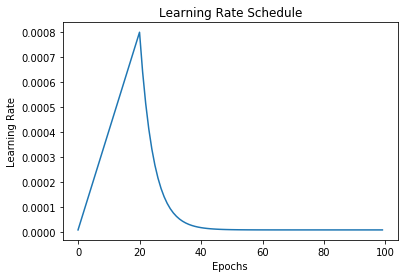

In [12]:
def build_lrfn(lr_start          = 0.00001, 
               lr_max            = 0.0008, 
               lr_min            = 0.00001, 
               lr_rampup_epochs  = 20, 
               lr_sustain_epochs = 0, 
               lr_exp_decay      = 0.8):
    
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr

    return lrfn

lrfn = build_lrfn()
lr = LearningRateScheduler(lrfn, verbose=0)

plt.plot([lrfn(epoch) for epoch in range(EPOCHS)])
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()

### 4.02 Define Baseline Model

The below model was the original architecture, however when we conduct our Bayesian Hyperparameter search, we'll be playing around with the architecture of this baseline model a little. Parameter tuning will affect the model depth as well as the numbers of nodes at each layer, the dropout layers, activation functions and optimisers.

In [13]:
def get_model(X_data, numerical_cols, categorical_cols, use_embedding=USE_EMBEDDING):
    
    if use_embedding == True:
        inputs = []
        embeddings = []

        for col in categorical_cols:
            # Create categorical embedding
            input_ = Input(shape=(1,))
            input_dim = int(X_data[col].max() + 1)
            embedding = Embedding(input_dim=input_dim, output_dim=10, input_length=1)(input_)
            embedding = Reshape(target_shape=(10,))(embedding)
            inputs.append(input_)
            embeddings.append(embedding)

        input_numeric = Input(shape=(len(numerical_cols),))
        embedding_numeric = Dense(8192, activation='relu')(input_numeric) 
        inputs.append(input_numeric)
        embeddings.append(embedding_numeric)

        x = Concatenate()(embeddings)
        
    if use_embedding == False:
        input_ = Input(shape=(X_data.shape[1], ))
        x = Dense(8192, activation='relu')(input_)
        
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) 
    
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    output = Dense(y.shape[1], activation='sigmoid')(x)

    if use_embedding == True:
        model = Model(inputs, output)
    elif use_embedding == False:
        model = Model(input_, output)
    
    return model

In [14]:
def metric(y_true, y_pred):
     return binary_crossentropy(y_true, y_pred).numpy().mean()

### 4.03 Bayesian Hyperparameter Search

Here we will conduct Bayesian hyperparameter search for a number of different parameters in our model - and save the best performing model for each fold. Some of what was coded above will be overwritten, but I wanted to leave the above model in the notebook so we have a record of what our baseline model was before we conducted hyperparameter tuning.

In [15]:
# Redefine hyperparamater constants
EPOCHS           = 100
SEED             = 19
np.random.seed(SEED)
SCALER_METHOD    = RobustScaler()
FEATURE_SELECTOR = RandomForestClassifier(random_state=SEED)
KFOLDS           = 2
MODEL_TO_USE     = 'nn'
model_name_save  = MODEL_TO_USE + '_final_classifier_seed' + str(SEED)

# Create model directory path if does not exist already
if not os.path.exists(f'models/{model_name_save}'):
    os.mkdir(f'models/{model_name_save}')

# Define hyperparameter search dimensions
dim_num_features     = Integer(low=300, high=900, name='num_features')
dim_num_components   = Integer(low=20,  high=300,  name='num_components')
dim_learning_rate    = Real(low=1e-4,   high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=1,   high=6,    name='num_dense_layers')
dim_num_input_nodes  = Integer(low=1,   high=4096, name='num_input_nodes')
dim_num_dense_nodes  = Integer(low=1,   high=4096, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu','leaky_relu','elu','threshold_relu'], name='activation')
dim_batch_size       = Integer(low=1,   high=64,   name='batch_size')
dim_patience         = Integer(low=3,   high=15,   name='patience')
dim_optimiser = Categorical(categories=['sgd','adam','rms_prop','ada_delta','ada_grad',
                                        'ada_max','n_adam','ftrl'], name='optimiser')
dim_optimiser_decay  = Real(low=1e-6,   high=1e-2, name='optimiser_decay')
dim_dropout_layer = Categorical(categories=['dropout','gaussian_dropout','alpha_dropout'],name='dropout_layer')
dim_dropout_val      = Real(low=0.1,    high=0.8,  name='dropout_val')
dim_use_embedding    = Integer(low=0,   high=1,    name='use_embedding')


dimensions = [dim_num_features,
              dim_num_components,
              dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_batch_size,
              dim_patience,
              dim_optimiser,
              dim_optimiser_decay,
              dim_dropout_layer,
              dim_dropout_val,
              dim_use_embedding
             ]

# Set default hyperparameters
default_parameters = [
    500,       # num_features
    200,       # num_components
    1e-3,      # learning_rate
    1,         # num_dense_layers
    512,       # num_input_nodes
    16,        # num_dense_nodes
    'relu',    # activation
    64,        # batch_size
    3,         # patience
    'adam',    # optimiser
    1e-3,      # optimiser_decay
    'dropout', # dropout_layer
    0.1,       # dropout_val
    1          # use_embedding
]

### 4.04 Train Model with Bayesian Hyperparameter Search

In [16]:
# Define CV strategy
kf = KFold(n_splits=KFOLDS, random_state=SEED)
loss_scores = []
best_params = pd.DataFrame(columns=['kfold','selected_features','num_features',
                                    'num_components','use_embedding','seed'])

for fold, (tdx, vdx) in enumerate(kf.split(X, y)):
    print(f'FOLD {fold}')
    print('--------------------------------------------------------------------------------------------------')
    # Create name to save model by
    model_save_name = 'models/' + model_name_save + '/' + model_name_save + '_' + str(fold) + '.h5'
    model_save_name_temp = 'models/' + model_name_save + '/' + 'TEMP_'+ model_name_save+ '_' + str(fold) + '.h5'    
    
    @use_named_args(dimensions=dimensions)
    def get_hyperopts(num_features,
                      num_components,
                      learning_rate, 
                      num_dense_layers, 
                      num_input_nodes, 
                      num_dense_nodes,
                      activation, 
                      batch_size,
                      patience,
                      optimiser,
                      optimiser_decay,
                      dropout_layer,
                      dropout_val,
                      use_embedding):

        # Define key parameters - these are affected by parameter search so must be done inside function
        NUM_FEATURES     = num_features
        NUM_COMPONENTS   = num_components
        PCA_METHOD       = PCA(n_components=NUM_COMPONENTS, random_state=SEED)
        BATCH_SIZE       = batch_size
        PATIENCE         = patience
        USE_EMBEDDING    = use_embedding

        
        # Fetch in-fold data
        X_tdx, X_vdx, y_tdx, y_vdx = X.iloc[tdx, :], X.iloc[vdx, :], y.iloc[tdx, :], y.iloc[vdx, :]

        # Transform data
        X_tdx, X_vdx, num_cols, cat_cols, selected_features = transform_feature_set(X_tdx, X_vdx, y_tdx, y_vdx, 
                                                                                    verbose=1,
                                                                                    num_features=NUM_FEATURES,
                                                                                    pca=PCA_METHOD) 

        # Define activation layers
        if activation == 'relu':
            ACTIVATION = ReLU()
        elif activation == 'leaky_relu':
            ACTIVATION = LeakyReLU()
        elif activation == 'elu':
            ACTIVATION = ELU()
        elif activation == 'threshold_relu':
            ACTIVATION = ThresholdedReLU()

        # Define regularisation layers
        if dropout_layer == 'dropout':
            REG_LAYER = Dropout(dropout_val)
        elif dropout_layer == 'gaussian_dropout':
            REG_LAYER = GaussianDropout(dropout_val)
        elif dropout_layer == 'alpha_dropout':
            REG_LAYER = AlphaDropout(dropout_val)

        # Define optimisers #
        if optimiser == 'sgd':
            OPTIMISER = SGD(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'adam':
            OPTIMISER = RMSprop(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'rms_prop':
            OPTIMISER = Adam(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ada_delta':
            OPTIMISER = Adadelta(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ada_grad':
            OPTIMISER = Adagrad(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ada_max':
            OPTIMISER = Adamax(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'n_adam':
            OPTIMISER = Nadam(lr=learning_rate, decay=optimiser_decay)
        elif optimiser == 'ftrl':
            OPTIMISER = Ftrl(lr=learning_rate, decay=optimiser_decay)

        ## BUILD MODEL BASED ON INPUTTED BAYESIAN HYPERPARAMETERS ##
        # Input layer #
        if USE_EMBEDDING == 1:
            inputs = []
            embeddings = []
            for col in cat_cols:
                # Create categorical embedding for each categorical feature
                input_ = Input(shape=(1,))
                input_dim = int(X_tdx[col].max() + 1)
                embedding = Embedding(input_dim=input_dim, output_dim=10, input_length=1)(input_)
                embedding = Reshape(target_shape=(10,))(embedding)
                inputs.append(input_)
                embeddings.append(embedding)
            input_numeric = Input(shape=(len(num_cols),))
            embedding_numeric = Dense(num_input_nodes)(input_numeric) 
            embedding_numeric = ACTIVATION(embedding_numeric) 
            inputs.append(input_numeric)
            embeddings.append(embedding_numeric)
            x = Concatenate()(embeddings)
        if USE_EMBEDDING == 0:
            input_ = Input(shape=(X_tdx.shape[1], ))
            x = Dense(num_input_nodes)(input_)
        # Hidden layers #
        for i in range(num_dense_layers):
            layer_name = f'layer_dense_{i+1}'
            x = Dense(num_dense_nodes, name=layer_name)(x)
            x = ACTIVATION(x)
            x = BatchNormalization()(x)
            x = REG_LAYER(x) 
        # Output layer #
        output = Dense(y.shape[1], activation='softmax')(x)

        if USE_EMBEDDING == 1:
            model = Model(inputs, output)
        elif USE_EMBEDDING == 0:
            model = Model(input_, output)

        
        # COMPILE MODEL #
        model.compile(optimizer=OPTIMISER, 
                      loss='binary_crossentropy')

        # Define learning rate schedule
        lr = LearningRateScheduler(lrfn, verbose=0)
        
        # Define early stopping parameters
        es = EarlyStopping(monitor='val_loss', 
                           mode='min',
                           restore_best_weights=True, 
                           verbose=0, 
                           patience=PATIENCE)
        
        # Define model checkpoint parameters
        mc = ModelCheckpoint(filepath=model_save_name_temp, 
                             save_best_only=True, 
                             save_weights_only=False,
                             monitor='val_loss', 
                             mode='min',
                             verbose=0)

        if USE_EMBEDDING == 1:
            # Separate data to fit into embedding and numerical input layers
            X_tdx = [np.absolute(X_tdx[i]) for i in cat_cols] + [X_tdx[num_cols]]
            X_vdx = [np.absolute(X_vdx[i]) for i in cat_cols] + [X_vdx[num_cols]]

        # FIT MODEL #
        print('TRAINING...')
        history = model.fit(X_tdx, y_tdx,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            callbacks = [es, lr, mc],
                            verbose=0,
                            validation_split=0.25
                           )
        
        # Get val_loss for the best model (one saved with ModelCheckpoint)
        loss = min(history.history['val_loss'])
        print(f'CURRENT LOSS: \t\t{loss}')
        
        # Save best loss and parameters to global memory
        global best_loss
        global best_params

        # If the classification loss of the saved model is improved
        if loss < best_loss:
            model.save(model_save_name)
            best_loss = loss
            
            # Save transformed validation arrays (so they can be used for prediction)
            global X_vdx_best_model, y_vdx_best_model
            X_vdx_best_model, y_vdx_best_model = X_vdx, y_vdx
            
            ### SAVE MODEL PARAMETERS ### 
            best_params = best_params.loc[best_params.kfold != fold]
            best_params = best_params.append({'kfold'            : fold,
                                              'selected_features': selected_features,
                                              'num_features'     : NUM_FEATURES,
                                              'num_components'   : NUM_COMPONENTS,
                                              'use_embedding'    : USE_EMBEDDING,
                                              'seed'             : SEED}, 
                                             ignore_index=True)
            best_params.to_csv('final_classifier_parameters/' + model_name_save + '.csv', index=False)
            
        print(f'BEST LOSS: \t\t{best_loss}\n')

        del model
        k.clear_session()
        return(loss)
    
    ## RUN BAYESIAN HYPERPARAMETER SEARCH ##
    print('RUNNING PARAMETER SEARCH...\n')
    time.sleep(2)
    best_loss = np.Inf
    search_iteration = 1
    
    gp_result = gp_minimize(func         = get_hyperopts,
                            dimensions   = dimensions,
                            acq_func     = 'EI', # Expected Improvement.
                            n_calls      = 50,
                            noise        = 0.01,
                            n_jobs       = -1,
                            kappa        = 5,
                            x0           = default_parameters,
                            random_state = SEED
                           )
    
    
    print('\nSEARCH COMPLETE.')
    print('MAKING VALIDATION PREDICTIONS...')
    
    # Load best model
    model = load_model(model_save_name)
    # Make validation predictions
    preds = model.predict(X_vdx_best_model)
    
    # Calculate OOF loss 
    oof_loss = metric(np.array(y_vdx_best_model), np.array(preds))

    print('FOLD ' + str(fold) + ' LOSS: ' + str(oof_loss))
    print('--------------------------------------------------------------------------------------------------')
    time.sleep(2)
    loss_scores.append(oof_loss)

    # Clean up
    gc.collect()
    os.remove(model_save_name_temp)

FOLD 0
--------------------------------------------------------------------------------------------------
RUNNING PARAMETER SEARCH...

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
517 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 200
TRAIN SHAPE: 		(11907, 202)
VALIDATION SHAPE: 	(11907, 202)
TRAINING...
CURRENT LOSS: 		0.018638930950773056
BEST LOSS: 		0.018638930950773056

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
459 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 136
TRAIN SHAPE: 		(11907, 138)
VALIDATION SHAPE: 	(11907, 138)
TRAINING...
CURRENT LOSS: 		0.02505427516222896
BEST LOSS: 		0.018638930950773056

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
559 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 187
TRAIN SHAPE: 		(11907, 189)
VALIDATION SHAPE: 	(11907, 189)
TRAINING...
CU

W1130 23:17:40.011047 140298787333952 nn_ops.py:4372] Large dropout rate: 0.537026 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


NUMBER OF PRINCIPAL COMPONENTS: 273
TRAIN SHAPE: 		(11907, 275)
VALIDATION SHAPE: 	(11907, 275)


W1130 23:17:40.046289 140298787333952 nn_ops.py:4372] Large dropout rate: 0.537026 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1130 23:17:40.080121 140298787333952 nn_ops.py:4372] Large dropout rate: 0.537026 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1130 23:17:40.113681 140298787333952 nn_ops.py:4372] Large dropout rate: 0.537026 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1130 23:17:40.225696 140298787333952 nn_ops.py:4372] Large dropout rate: 0.537026 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


TRAINING...
CURRENT LOSS: 		0.023078378897471878
BEST LOSS: 		0.018638930950773056

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
272 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 21
TRAIN SHAPE: 		(11907, 23)
VALIDATION SHAPE: 	(11907, 23)
TRAINING...
CURRENT LOSS: 		0.02244036524942308
BEST LOSS: 		0.018638930950773056

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
521 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 214
TRAIN SHAPE: 		(11907, 216)
VALIDATION SHAPE: 	(11907, 216)
TRAINING...
CURRENT LOSS: 		0.02127395842604772
BEST LOSS: 		0.018638930950773056

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
162 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 44
TRAIN SHAPE: 		(11907, 46)
VALIDATION SHAPE: 	(11907, 46)
TRAINING...
CURRENT LOSS: 		0.023384411518014955
BEST LOSS: 		0.01863893

658 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 287
TRAIN SHAPE: 		(11907, 289)
VALIDATION SHAPE: 	(11907, 289)
TRAINING...
CURRENT LOSS: 		0.02276133320509867
BEST LOSS: 		0.018638930950773056

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
117 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 71
TRAIN SHAPE: 		(11907, 73)
VALIDATION SHAPE: 	(11907, 73)
TRAINING...
CURRENT LOSS: 		0.019439229036709197
BEST LOSS: 		0.018638930950773056

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
682 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 38
TRAIN SHAPE: 		(11907, 40)
VALIDATION SHAPE: 	(11907, 40)
TRAINING...
CURRENT LOSS: 		0.023343518481464404
BEST LOSS: 		0.018638930950773056

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
712 features removed in feature selection.
APPLYING PCA...
NUMBER OF PR

TRAINING...
CURRENT LOSS: 		0.021507388749464892
BEST LOSS: 		0.018761615805405477

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
162 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 44
TRAIN SHAPE: 		(11907, 46)
VALIDATION SHAPE: 	(11907, 46)
TRAINING...
CURRENT LOSS: 		0.024495595275885233
BEST LOSS: 		0.018761615805405477

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
606 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 77
TRAIN SHAPE: 		(11907, 79)
VALIDATION SHAPE: 	(11907, 79)
TRAINING...
CURRENT LOSS: 		0.024082443624019102
BEST LOSS: 		0.018761615805405477

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
317 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 50
TRAIN SHAPE: 		(11907, 52)
VALIDATION SHAPE: 	(11907, 52)
TRAINING...
CURRENT LOSS: 		0.02220050594839807
BEST LOSS: 		0.0187616158

682 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 38
TRAIN SHAPE: 		(11907, 40)
VALIDATION SHAPE: 	(11907, 40)
TRAINING...
CURRENT LOSS: 		0.02385471220640356
BEST LOSS: 		0.018613407980221448

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
244 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 24
TRAIN SHAPE: 		(11907, 26)
VALIDATION SHAPE: 	(11907, 26)
TRAINING...
CURRENT LOSS: 		0.019332706026024653
BEST LOSS: 		0.018613407980221448

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
163 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRINCIPAL COMPONENTS: 287
TRAIN SHAPE: 		(11907, 289)
VALIDATION SHAPE: 	(11907, 289)
TRAINING...
CURRENT LOSS: 		0.02321679255373583
BEST LOSS: 		0.018613407980221448

ENGINGEERING FEATURES...
APPLYING SCALER...
APPLYING FEATURE SELECTOR...
118 features removed in feature selection.
APPLYING PCA...
NUMBER OF PRI

--------------
FOLD SCORES
--------------
0    0.018156
1    0.018677
dtype: float64

--------------
FOLD STATS
--------------
count    2.000000
mean     0.018417
std      0.000368
min      0.018156
25%      0.018286
50%      0.018417
75%      0.018547
max      0.018677
dtype: float64


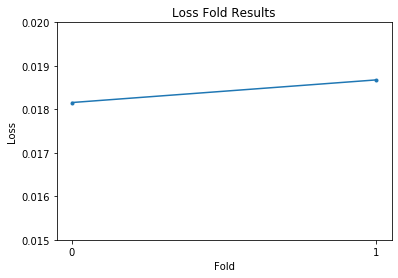

In [17]:
print(f'--------------\nFOLD SCORES\n--------------\n{pd.Series(loss_scores)}')
print(f'\n--------------\nFOLD STATS\n--------------\n{pd.Series(loss_scores).describe()}')

plt.plot(pd.Series(loss_scores).index, pd.Series(loss_scores), marker='.')
plt.title('Loss Fold Results')
plt.xlabel('Fold')
plt.xticks(np.arange(0, KFOLDS, step=1))
plt.ylabel('Loss')
plt.ylim([0.015, 0.02])
plt.show()

In [18]:
## SAVE SCORES ##
# Convert to dataframe
loss_scores_df = pd.DataFrame(loss_scores).reset_index().rename(columns={'index':'fold', 0:'loss'})
# Write to csv
loss_scores_df.to_csv('scores/' + model_name_save + '.csv', index=False)